# 1. Librerie

In [1]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy import stats
import pickle
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

2023-06-07 18:08:25.504944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model (to make our detection)
mp_drawing = mp.solutions.drawing_utils # Drawing utilities (to draw them)

In [3]:
def mediapipe_detection(image, model):

    """
    Esegue la rilevazione dei landmark delle mani utilizzando il modello di MediaPipe.

    Input:
    - image: l'immagine di input (frame) su cui effettuare la rilevazione dei landmark
    - model: il modello di MediaPipe per la rilevazione dei landmark

    Output:
    - image: l'immagine di input modificata, con i landmark disegnati
    - results: gli oggetti 'results' contenenti i risultati della rilevazione dei landmark
    """

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    """
    Disegna i landmark delle mani sull'immagine utilizzando i risultati ottenuti dalla rilevazione di MediaPipe.

    Input:
    - image: l'immagine su cui disegnare i landmark
    - results: i risultati ottenuti dalla rilevazione di MediaPipe

    Output:
    - None
    """

    # Disegna i landmark della mano sinistra e le relative connessioni
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

    # Disegna i landmark della mano destra e le relative connessioni
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):
    """
    Disegna i landmark delle mani sull'immagine utilizzando uno stile personalizzato.

    Input:
    - image: l'immagine su cui disegnare i landmark
    - results: i risultati ottenuti dalla rilevazione di MediaPipe

    Output:
    - None
    """

    # Disegna i landmark della mano sinistra e le relative connessioni con uno stile personalizzato
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )

    # Disegna i landmark della mano destra e le relative connessioni con uno stile personalizzato
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [6]:
def extract_keypoints(results):
    """
    Estrae i punti chiave dei landmark delle mani dai risultati di MediaPipe.

    Input:
    - results: i risultati ottenuti dalla rilevazione di MediaPipe

    Output:
    - keypoints: un array numpy contenente i punti chiave dei landmark delle mani
    """

    # Estrae i punti chiave dei landmark della mano sinistra se disponibili, altrimenti crea un array di zeri
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

    # Estrae i punti chiave dei landmark della mano destra se disponibili, altrimenti crea un array di zeri
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    # Concatena i punti chiave delle mani sinistra e destra in un unico array
    keypoints = np.concatenate([lh, rh])

    return keypoints

In [7]:
# Azioni da riconoscere
actions = np.array(['0','1', '2', '3','4','5','altro'])

# 3. Import Neural Network

In [8]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(126,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.load_weights('modello/action.h5')

# 4. Test in Real Time

In [9]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]

def prob_viz(res, actions, input_frame, colors):

    """
    La funzione visualizza una barra di probabilità colorata per ogni azione prevista.
    Input:
    - res: Array di probabilità delle azioni previste.
    - actions: Array delle etichette delle azioni.
    - input_frame: Frame di input su cui disegnare le barre di probabilità.
    - colors: Lista dei colori corrispondenti alle azioni.
    
    Output:
    - output_frame: Frame di output con le barre di probabilità disegnate.
    """

    # Creazione di una copia del frame di input
    output_frame = input_frame.copy()
    
    for num, prob in enumerate(res):
        # Disegno del rettangolo colorato proporzionale alla probabilità dell'azione
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        
        # Aggiunta del testo dell'azione corrispondente sopra il rettangolo
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return output_frame


In [10]:
# 1. Nuove variabili per la rilevazione
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)

# Imposta il modello di MediaPipe
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Leggi il frame
        ret, frame = cap.read()

        # Effettua le rilevazioni
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Disegna i landmark stilizzati sull'immagine
        draw_styled_landmarks(image, results)
        
        # 2. Logica di predizione
        keypoints = extract_keypoints(results)
        
        res = model.predict(np.expand_dims(keypoints, axis=0))[0]
        print(actions[np.argmax(res)])
        predictions.append(np.argmax(res))
            
        # 3. Logica di visualizzazione
        if np.unique(predictions[-10:])[0] == np.argmax(res) and res[np.argmax(res)] > threshold:
            if len(sentence) > 0: 
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])

        if len(sentence) > 5: 
            sentence = sentence[-5:]

        # Visualizza le probabilità
        image = prob_viz(res, actions, image, colors)
        
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Mostra il feed alla schermata
        cv2.imshow('OpenCV Feed', image)

        # Interrompi in modo corretto
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


2023-06-07 18:08:41.934 python[3701:176667] mac-virtualcam(DAL): PlugInMain version=1.3.0
2023-06-07 18:08:41.934 python[3701:176667] mac-virtualcam(DAL): HardwarePlugIn_QueryInterface 
2023-06-07 18:08:41.935 python[3701:176667] mac-virtualcam(DAL): HardwarePlugIn_Release sRefCount now = 0
2023-06-07 18:08:41.935 python[3701:176667] mac-virtualcam(DAL): HardwarePlugIn_InitializeWithObjectID self=0x145ab1478
2023-06-07 18:08:41.935 python[3701:176667] mac-virtualcam(DAL): HardwarePlugIn_ObjectSetPropertyData OBSDALDevice(33) kCMIOObjectPropertyListenerAdded self=0x145ab1478 data(int)=1684629094
2023-06-07 18:08:41.936 python[3701:176667] mac-virtualcam(DAL): HardwarePlugIn_ObjectSetPropertyData OBSDALDevice(33) kCMIOObjectPropertyListenerAdded self=0x145ab1478 data(int)=1869180523
2023-06-07 18:08:41.936 python[3701:176667] mac-virtualcam(DAL): HardwarePlugIn_ObjectSetPropertyData OBSDALDevice(33) kCMIOObjectPropertyListenerAdded self=0x145ab1478 data(int)=1885762592
2023-06-07 18:08:4

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 277ms/step
altro
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
altro
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
altro
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
altro
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
altro
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
altro
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
altro
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
altro
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [=================

2023-06-07 18:09:19.956 python[3701:177315] mac-virtualcam(DAL): PlugIn unhandled hasPropertyWithAddress for Unknown selector: ddsc


In [11]:
cap.release()
cv2.destroyAllWindows()

# 5. Testing from static image

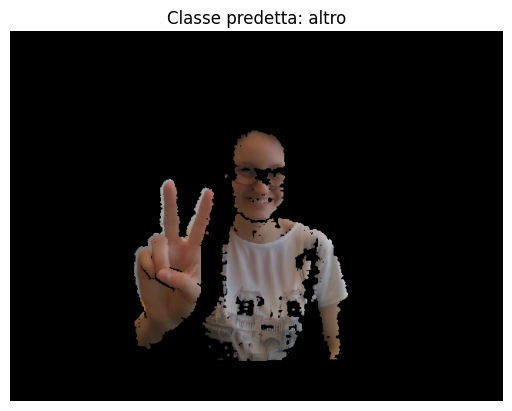

In [12]:
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Carica e preprocessa l'immagine
    frame = cv2.imread('Frame Depth/2/alice_32739_dx.png')
    
    # Effettua le rilevazioni
    image, results = mediapipe_detection(frame, holistic)

    # Disegna i landmark stilizzati sull'immagine
    draw_styled_landmarks(image, results)

    # Estrazione dei punti chiave dai risultati
    keypoints = extract_keypoints(results)

    # Esegue la predizione utilizzando il modello
    res = model.predict(np.expand_dims(keypoints, axis=0), verbose=0)[0]

    # Mostra l'immagine con i landmark
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Classe predetta: {}".format(actions[np.argmax(res)]))

    plt.show()
